# SSC_ATACseq_Analysis.Pipeline.NormSamples(Add Macrophage)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nx
import gc
import psutil
import scipy.stats
#import Thestral
from scipy.stats.mstats import gmean
from matplotlib_venn import venn2, venn2_circles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import community
import matplotlib.gridspec as gridspec
import random
import itertools


In [8]:

#Functions
def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def Read(File):
    return pd.read_table(File,sep='\t',index_col=0)

def ReadBed(File):
    Bed=pd.read_table(File,sep='\t',index_col=None,header=None)
    Bed.index=Bed[3]
    return Bed

def Save(DF,File):
    DF.to_csv(File,sep='\t')

def SaveBed(Bed,File):
    Bed.to_csv(File,sep='\t',index=False,header=False)
    
def GetState(i):
    if 'Norm' in i: return 'Norm'
    if 'Arm' in i: return 'Arm'
    if 'Back' in i:return 'Back'

def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def SizeFactor(DF):return (DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)

def Ttest1(A,B,Index_List):
    return pd.Series(scipy.stats.ttest_ind(A,B,axis=1)[1],index=Index_List)

def Ttest(A,B,Index_List):
    P=[]
    for i in Index_List:
        _,p=scipy.stats.ttest_ind(list(A.loc[i].dropna()),list(B.loc[i].dropna()))
        P.append(p)
    return pd.Series(P,index=Index_List)


def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

    
# input A/B is DataFrame whose value is after taking log2
def Diff_FDR(A,B,fdc,fdr):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    FDR=pd.Series(p_adjust_bh(Pval.values), index=Indexs)
    return FDC,FDR,list(A2[(FDC>fdc)&(FDR<fdr)].index),list(A2[(FDC<-fdc)&(FDR<fdr)].index)
    

def Diff_Pval(A,B,fdc,p):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))           
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    return FDC,Pval,list(A2[(FDC>fdc)&(Pval<p)].index),list(A2[(FDC<-fdc)&(Pval<p)].index)
    

In [9]:
#Inputfiles
AllF='/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_AllCelltype_AllClinicalState/atac.count'                                             
#AllCommonF='/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_NormSScCommon/Add_Macrophage/NormSSc.raw.order.txt'
NormF='/Users/liuqian/Documents/A_SSC_project/A_Code_available/Norm/NormSkin.raw.txt'
#ArmF='/Users/liuqian/Documents/A_SSC_project/Arm/SSC_Arm_raw.txt'
#BackF='/Users/liuqian/Documents/A_SSC_project/Back/SSC_Back_raw.txt'

# AllDir=''
# AllCommonDir='/Users/liuqian/Documents/A_SSC_project/All'
# NormDir='/Users/liuqian/Documents/A_SSC_project/Norm'
# ArmDir='/Users/liuqian/Documents/A_SSC_project/Arm'
# BackDir='/Users/liuqian/Documents/A_SSC_project/Back'

#AllBed='/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_AllCelltype_AllClinicalState/atac.merged.peak.list'
#AllCommonBed='/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_NormSScCommon/Add_Macrophage/NormSScPeaks.bed'
NormBed='/Users/liuqian/Documents/A_SSC_project/Norm/NormSkinPeaks.bed'

#Output Dir
outDir="/Users/liuqian/Documents/A_SSC_project/A_Code_available"
#outDirAll="/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_AllCelltype_AllClinicalState"
outDirNorm="/Users/liuqian/Documents/A_SSC_project/A_Code_available/Norm"
#outDirAllCommon="/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_NormSScCommon/Add_Macrophage"
#dataDir='/Users/liuqian/Documents/A_SSC_project/A_Code_available/SourceData'


#SNP 
GRASPFile='/Users/liuqian/Documents/ATAC-seq_project/ForLiuQian/All_GRASP2_SNP.txt'
GRASPBed='/Users/liuqian/Documents/A_SSC_project/Norm/SNP_Enrichment/All_GRASP2_SNP.bed'
SNPBedFile="/Users/liuqian/Documents/A_SSC_project/A_Code_available/Published_SNPBed.txt"



In [10]:
#Color
ClusterColorsDict={'CD4':'#EC2427','CD8':'#F15E25','Mac':'#231F20','Fib':'#3B54A4','EC':'#EB0D8C','DC':'#6CBE46','LC':'#34C5F4','KC':'#F6EC13','CD31':'#EB0D8C'}          
ClusterMarkerDict={'Norm':'o','Back':'^','Arm':'s'}
StateColorDict={'Norm':'#1B5B9C','Arm':'#C94540','Back':'coral','Norm-Arm-Back':'#8B8C8F','Arm-Back':'#4D2A7C','Norm-Arm':'#675EA9','Norm-Back':'#4B86C6'} 




## QC Analysis

In [23]:
outDir="/Users/liuqian/Documents/A_SSC_project/A_Code_available"
Dir=os.path.join(outDir,'QC')
FragDir=os.path.join(Dir,'FragmentDistribution')
TSSDir=os.path.join(Dir,'TSS')


In [30]:
def get_Fig_ax(x_label,y_label):
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(6,5.0))
    ax=fig.add_axes([0.25,0.25,0.55,0.65])
    ax.tick_params(axis='y',length=7,labelsize=30,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=30,direction='out')
    ax.set_ylabel(y_label.capitalize(),fontsize=35)
    ax.set_xlabel(x_label.capitalize(),fontsize=35)
    if x_label=='length':
        ax.set_ylim([-0.0005,0.015])
    elif x_label=='center':
        ax.set_ylim([-1,15])
    return fig,ax

def get_interval(L):
    Int=scipy.stats.norm.interval(0.80,np.mean(L),np.std(L))
    return Int[0],Int[1]

def DrawQC(fig,ax,Xs,Ys,color):
    MeanY=[np.mean(i) for i in Ys]
    Int=[get_interval(i) for i in Ys]
    IntY1=[i[0] for i in Int]
    IntY2=[i[1] for i in Int]
    ax.fill_between(Xs,IntY1,IntY2,edgecolor='none',facecolor=color,alpha=0.2)
    ax.plot(Xs,MeanY,color=color,alpha=1,linewidth=1.5)

def GetQC(File,x_label,y_label):
    DF=ReadTable(File)
    fig,ax=get_Fig_ax(x_label,y_label)
    Xs=[]
    Ys=[]
    for x in sorted(list(set(DF[x_label]))):
        Xs.append(x)
        Ys.append(list(DF[DF[x_label]==x][y_label]))
    return Xs,Ys


    
    

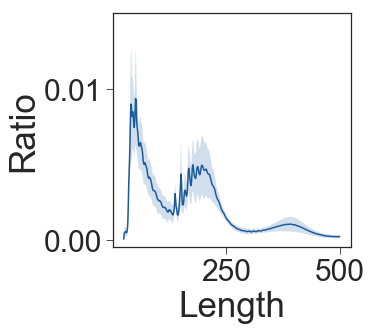

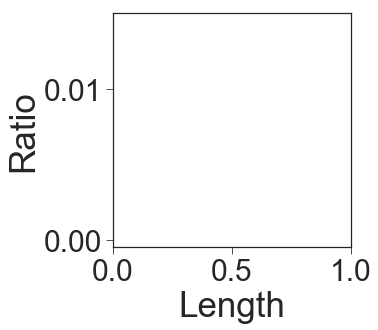

In [31]:
fig1,ax1=get_Fig_ax('length','ratio')
Xs_Norm,Ys_Norm=GetQC(os.path.join(FragDir,'Fragmentdistribution.Norm.txt'),'length','ratio')
DrawQC(fig1,ax1,Xs_Norm,Ys_Norm,'#1B5B9C')
fig1.savefig(os.path.join(FragDir, 'Fragmentdistribution.Norm.pdf'))
plt.show()



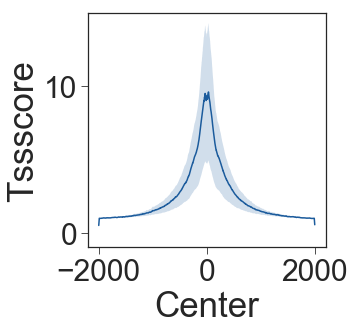

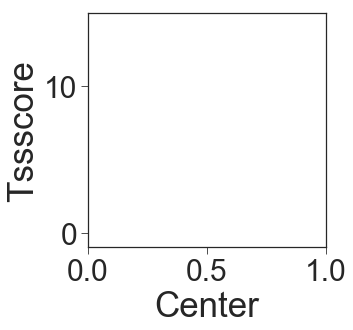

In [32]:
fig2,ax2=get_Fig_ax('center','TSSscore')
Xs_Norm,Ys_Norm=GetQC(os.path.join(TSSDir,'TSSscore.Norm.txt'),'center','TSSscore')
DrawQC(fig2,ax2,Xs_Norm,Ys_Norm,'#1B5B9C')
fig2.savefig(os.path.join(TSSDir, 'TSSscore.Norm.pdf'))
plt.show()



# Normalization

In [33]:
def NormLog(DF,label,method,O,outDir):
    def log(L):return np.array([math.log(i+1,2) for i in L])
    if method=='QNorm':
        print 'Do QNorm...'
        rank_mean=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
        DF=DF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
        print 'QNorm Done!'
    if method=='DEseq':
        print 'Do DEseq...'
        SizeFactor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
        DF=DF/SizeFactor
        outSizeFactor=os.path.join(outDir,'DEseq_sizeFactors.txt')
        SizeFactor.to_csv(outSizeFactor,sep='\t')
        print 'DEseq Done!'
    DFlog=DF.apply(log)
    if O:
        print 'Output file...'
        outfilelog=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.log2.txt')
        outfile=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.txt')
        DF.to_csv(outfile,sep='\t')
        DFlog.to_csv(outfilelog,sep='\t')
    return DF,DFlog


In [34]:
NormDF=Read(NormF)
NormDF_Norm,NormDF_Normlog=NormLog(NormDF,'NormSkin','QNorm',True,outDirNorm)


Do QNorm...
QNorm Done!
Output file...


# Sample ColorAnnotation

In [35]:

AllSampleColorDF=pd.DataFrame({'Celltype':[ClusterColorsDict[i.split('_')[0]] for i in list(NormDF)]}, index=list(NormDF))              
AllSampleColorDF['State']=[StateColorDict[GetState(i)] for i in AllSampleColorDF.index]



# Annotation Peaks

In [37]:
NormAnoF=os.path.join(outDirNorm,'NormPeaks.ano.txt')
Comd='annotatePeaks.pl {} hg19 > {}'.format(NormBed,NormAnoF)
os.system(Comd)


0

### Correlation Annalysis

In [38]:
NormAnoDF=ReadTable(NormAnoF)


In [39]:
DirNorm=os.path.join(outDirNorm,'SampleCorrelation')
Mkdir(DirNorm)


In [40]:
NormDF_Norm_Distal=NormDF_Norm.loc[NormAnoDF[abs(NormAnoDF['Distance to TSS'])>1000].index]


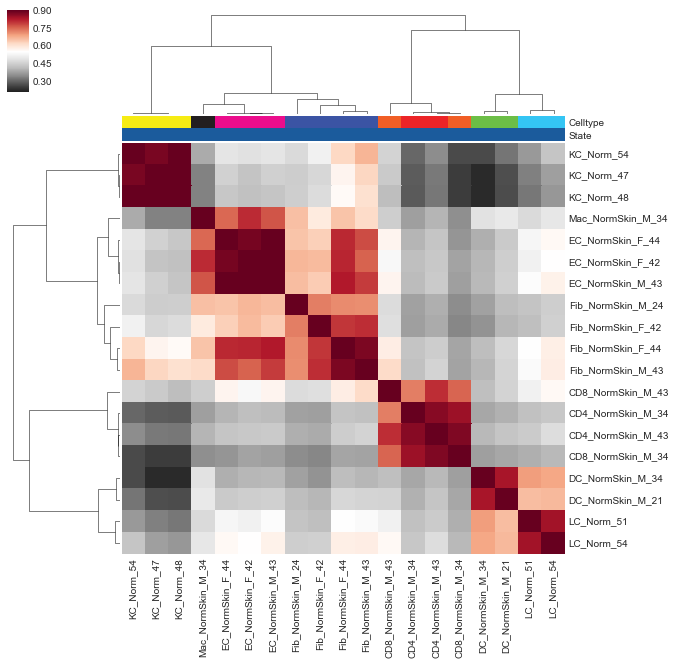

In [41]:

CorDF=NormDF_Norm_Distal.corr(method='pearson')
sns.clustermap(CorDF,cmap='RdGy_r',method='average', metric='correlation',vmax=0.9,vmin=0.2, col_colors=AllSampleColorDF)                 
plt.savefig(os.path.join(DirNorm,"DistalPeaks_NormSample_Correlation.pdf"))
plt.show()
Save(CorDF, os.path.join(DirNorm,'DistalPeaks_NormSample_PearsonCorrelation.txt'))



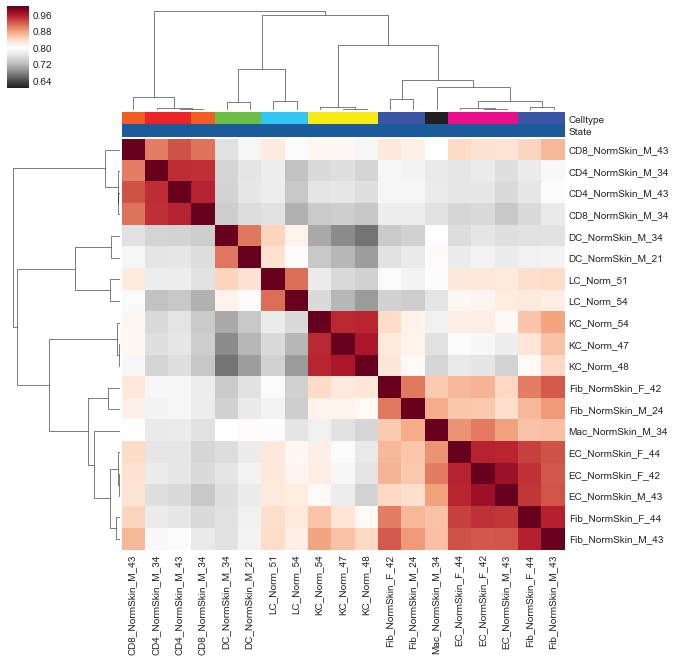

In [42]:
CorDF=NormDF_Norm.corr(method='pearson')
sns.clustermap(CorDF,cmap='RdGy_r',method='average', metric='correlation',vmax=1,vmin=0.6, col_colors=AllSampleColorDF)                 
plt.savefig(os.path.join(DirNorm,"AllPeaks_NormSample_Correlation.pdf"))
plt.show()
Save(CorDF, os.path.join(DirNorm,'AllPeaks_NormSample_PearsonCorrelation.txt'))



# PCA Analysis 

In [43]:
DirNorm=os.path.join(outDirNorm,'SamplePCA')

Mkdir(DirNorm)


In [46]:
def Pca(inDFP,outfigPrex,labelDF=None,colorhue='Celltype',colorDict=ClusterColorsDict,markerhue='State',markerDict=ClusterMarkerDict):
    print 'PCA!'
    pca=PCA(n_components=3)
    pca.fit(inDFP)
    pca_ratio=pca.explained_variance_ratio_
    newDatal=pd.DataFrame(np.transpose(pca.components_),index=inDFP.columns)
    labelDF=labelDF.loc[newDatal.index]          
    newDatal['Color']=labelDF[colorhue]
    if markerhue:
        newDatal['Marker']=labelDF[markerhue]
                
    def pca_2D(a,b,Txt):
        print '2D:'+str(a)+str(b)
        plt.style.use('seaborn-white')
        fig1=plt.figure(figsize=(6,6))
        ax1=fig1.add_axes([0.2,0.2,0.7,0.7])
        ax1.set_xlabel('PC{}({:.2f}%)'.format(a,pca_ratio[a-1]*100),fontsize=25)
        ax1.set_ylabel('PC{}({:.2f}%)'.format(b,pca_ratio[b-1]*100),fontsize=25)
        ax1.tick_params(axis='both',length=7,labelsize=25,direction='out')
        for i in newDatal.groupby(newDatal['Color']):
            subDF=i[1]
            cl=list(subDF['Color'])[0]
            C=colorDict[cl]
            if markerhue:
                for j in subDF.groupby(subDF['Marker']):
                    
                    ssubDF=j[1]
                    
                    #ml=ssubDF['Marker'][1]
                    ml=j[0]
                    M=markerDict[ml]
                    ax1.scatter(ssubDF[a-1],ssubDF[b-1],s=100,c=C,marker=M,alpha=0.75,edgecolors='none',label=cl+'-'+ml)
            else:
                M='o'
                ax1.scatter(subDF[a-1],subDF[b-1],s=100,c=C,marker=M,alpha=0.75,edgecolors='none',label=cl)
        ax1.legend(fontsize=10,markerscale=1,ncol=1,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0)    
        ax1.tick_params(axis='both',length=7,labelsize=25,direction='out')
        if Txt:
            outfig='{}.2D.{}-{}.Txt.pdf'.format(outfigPrex,str(a),str(b))
            for i in newDatal.index:
                ax1.text(newDatal[a-1][i],newDatal[b-1][i],i.split('T')[0],fontsize=5)
            plt.savefig(outfig)
        else:
            outfig='{}.2D.{}-{}.pdf'.format(outfigPrex,str(a),str(b))    
            plt.savefig(outfig)            

    pca_2D(1,2,True)
    pca_2D(1,3,True)
    pca_2D(2,3,True)
    pca_2D(1,2,False)
    pca_2D(1,3,False)
    pca_2D(2,3,False)
    plt.show()
                


In [47]:
LabelDF=pd.DataFrame({'Celltype':[i.split('_')[0] for i in list(NormDF)]}, index=list(NormDF)) 
LabelDF['State']=[GetState(i) for i in LabelDF.index]



PCA!
2D:12
2D:13
2D:23
2D:12
2D:13
2D:23


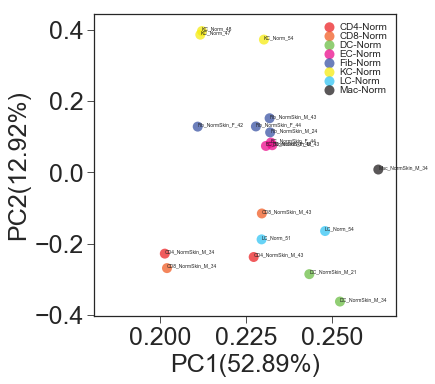

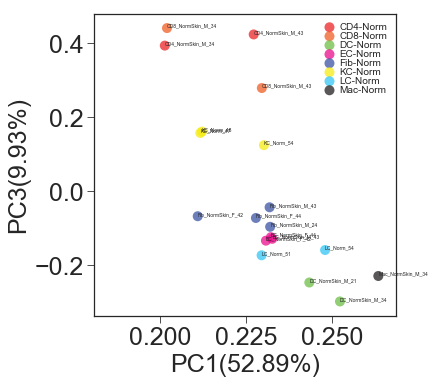

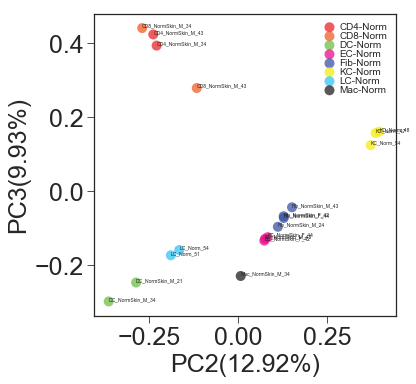

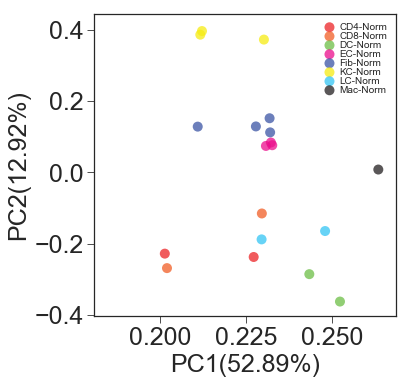

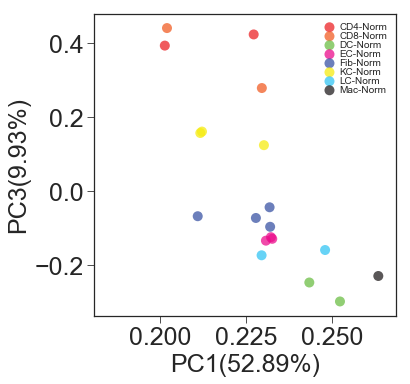

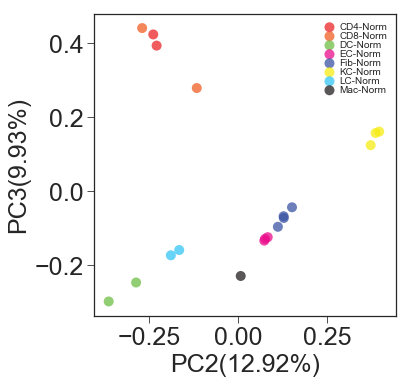

In [48]:
Pca(NormDF_Norm_Distal,os.path.join(DirNorm,'DistallPeaks_PCA'),labelDF=LabelDF,colorhue='Celltype',colorDict=ClusterColorsDict,markerhue='State',markerDict=ClusterMarkerDict)


PCA!
2D:12
2D:13
2D:23
2D:12
2D:13
2D:23


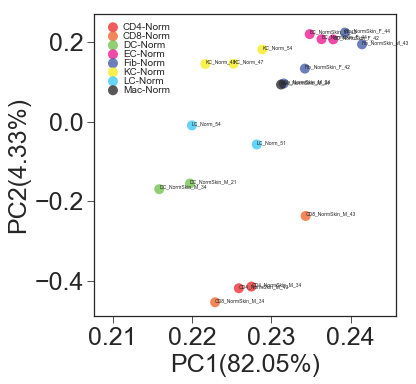

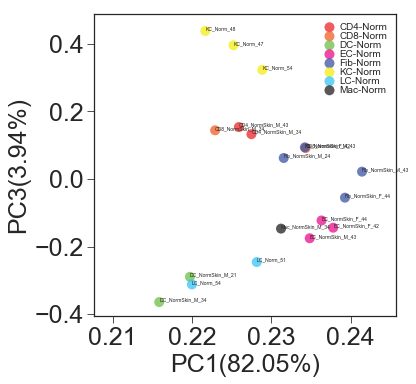

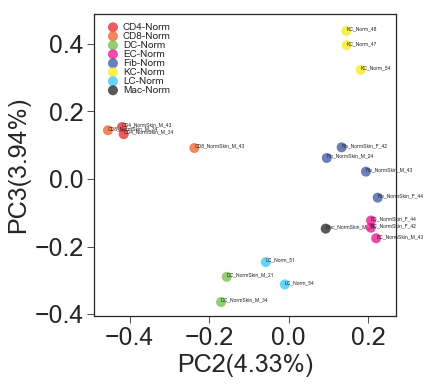

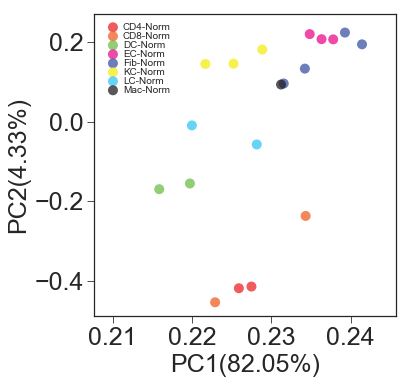

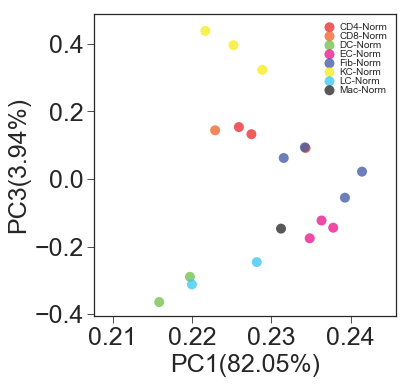

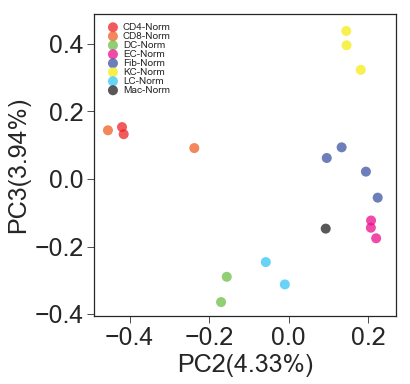

In [49]:
Pca(NormDF_Norm,os.path.join(DirNorm,'AllPeaks_PCA'),labelDF=LabelDF,colorhue='Celltype',colorDict=ClusterColorsDict,markerhue='State',markerDict=ClusterMarkerDict)



# Celltype specific Peaks

In [50]:

DirNorm=os.path.join(outDirNorm,'SampleCelltypeSpecific')
Mkdir(DirNorm)


In [52]:

#Celltype specific peaks selection
def CellTypeSpecificPeaks(DF,label,Bed,Order,outDir,ColorDF,cmap='YlGnBu',incov=0.5,outcov=0.5,f=1.5,p=0.01,DoNorm=True):
    Dir=os.path.join(outDir,'SpecificPeaks.incov_{}.outcov_{}.f_{}.p_{}'.format(incov,outcov,f,p))
    Mkdir(Dir)
    SampleUsed=[i for i in list(DF) if i.split('_')[0] in Order]
    DF=DF[SampleUsed]
    if DoNorm:
        NormDF,NormDFLog=NormLog(DF,label,'QNorm',True,outDir)
    else:
        NormDFLog=DF
    NormDFLog=NormDFLog[NormDFLog.apply(max,axis=1)>4]
    PEAK=[]
    SAMPLE=[]
    CellTypeSpecificPeaks_Dict={}
    for ct in Order:
        print ct
        CT=ct.split('-')
        IN=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] in CT]]
        if len(CT)==1:
            SAMPLE=SAMPLE+list(IN)
        OUT=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] not in CT]]
        outCOV=OUT.apply(scipy.stats.variation,axis=1)
        M=IN.apply(np.mean,axis=1)
        F=M-OUT.apply(np.mean,axis=1)
        
#        if ct=='Mac':
#            continue
            
        if len(list(IN))>1:
            inCOV=IN.apply(scipy.stats.variation,axis=1)
            P=pd.Series(scipy.stats.ttest_ind(IN,OUT,axis=1)[1],index=IN.index)
            Peaks=list(M[(inCOV<incov)&(outCOV<outcov)&(F>f)&(P<p)].sort_values().index)
        elif len(list(IN))==1:
            continue
            #Peaks=list(M[(outCOV<outcov)&(F>3)].sort_values().index)
        Data=NormDFLog.loc[Peaks]
        bed=Bed.loc[Peaks]
        Save(Data,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.txt'))
        SaveBed(bed,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.bed'))
        Peaks=[i for i in Peaks if i not in PEAK]
        print len(Peaks)
        CellTypeSpecificPeaks_Dict[ct]=Peaks
        PEAK=PEAK+Peaks
        
    DATA=NormDFLog[SAMPLE].loc[PEAK]
    BED=Bed.loc[PEAK]
    Save(DATA,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.txt'))
    SaveBed(BED,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.bed'))
    #ColorDF=pd.DataFrame({'CellType':[ClusterColorsDict[i.split('_')[0]] for i in SAMPLE]},index=SAMPLE)
    print 'Draw Figure ...'
    DATA.index=[' ']*len(DATA)
    fig=sns.clustermap(DATA,figsize=(6,6),row_cluster=False,col_cluster=False,cmap=cmap,vmin=2,vmax=8,xticklabels=[i.split('_')[0] for i in SAMPLE],col_colors=ColorDF)
    print 'Save Figure ...'
    fig.savefig(os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf'))
    print os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf')
    plt.show()
    print 'Done!'   
    
    fig=sns.clustermap(DATA.apply(scipy.stats.zscore,axis=1),figsize=(6,6),row_cluster=False,col_cluster=False,cmap=cmap,vmin=-2,vmax=2,xticklabels=[i.split('_')[0] for i in SAMPLE],col_colors=ColorDF)
    print 'Save Figure ...'
    fig.savefig(os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.Zscore.pdf'))
    plt.show()
    return CellTypeSpecificPeaks_Dict



Do QNorm...
QNorm Done!
Output file...
CD4


/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:977: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


828
CD4-CD8
2963
CD8
121
DC
1986
DC-LC
2896
LC
497
Mac
EC
370
Fib
1089
KC
3493
Draw Figure ...
Save Figure ...
/Users/liuqian/Documents/A_SSC_project/A_Code_available/Norm/SampleCelltypeSpecific/SpecificPeaks.incov_0.5.outcov_0.5.f_2.p_0.005/Celltype.specific.Peaks.QNorm.log.pdf


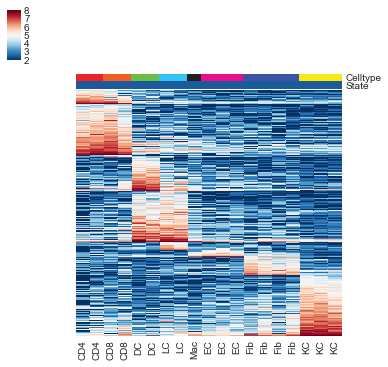

Done!
Save Figure ...


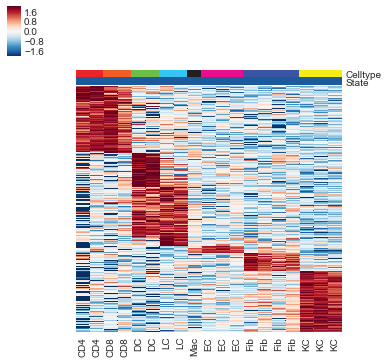

In [53]:
#Norm
NormBedDF=ReadBed(NormBed)
NormOrder=['CD4','CD4-CD8','CD8','DC','DC-LC','LC','Mac','EC','Fib','KC']
NormCellTypeSpecificPeaks_Dict=CellTypeSpecificPeaks(NormDF,'Norm',NormBedDF,NormOrder,DirNorm,AllSampleColorDF,cmap='RdBu_r',incov=0.5,outcov=0.5,f=2,p=0.005,DoNorm=True)    


# Ano Bed

In [54]:
#Input Dirs

def AnoBed(Dir):
    BedFiles=[i for i in os.listdir(Dir) if i[-3:]=='bed']
    for f in BedFiles:
        print f
        F=os.path.join(Dir,f)
        comd='/seq/homer/bin/annotatePeaks.pl {} hg19 > {}.ano.txt'.format(F,F)
        os.system(comd)
    
    

In [55]:

AnoBed('/Users/liuqian/Documents/A_SSC_project/A_Code_available/Norm/SampleCelltypeSpecific/SpecificPeaks.incov_0.5.outcov_0.5.f_2.p_0.005')



CD4-CD8.specific.Peaks.QNorm.log.bed
CD4.specific.Peaks.QNorm.log.bed
CD8.specific.Peaks.QNorm.log.bed
Celltype.specific.Peaks.QNorm.log.bed
DC-LC.specific.Peaks.QNorm.log.bed
DC.specific.Peaks.QNorm.log.bed
EC.specific.Peaks.QNorm.log.bed
Fib.specific.Peaks.QNorm.log.bed
KC.specific.Peaks.QNorm.log.bed
LC.specific.Peaks.QNorm.log.bed


# Genomica TF Enrichment 

In [58]:
#Input gxr file
NormGxrDir='/Users/liuqian/Documents/A_SSC_project/A_Code_available/Norm/SampleCelltypeSpecific/SpecificPeaks.incov_0.5.outcov_0.5.f_2.p_0.005/Genomica'                           



In [59]:

def Range(L):return max(L)-min(L)
def Genomic_Display(GxrFile,Dir,colormap='RdBu_r',LabelDF=None,vmax=50,colorLabel=['CelltypeColor'],topNum=100):
    GXR=Read(GxrFile)
    F1=((abs(GXR)>0).apply(sum,axis=1))>len(list(GXR))*0.1  #只保留那些至少在十分之一的样本中存在富集指数的TF
    GXR=GXR[F1]
    Index=GXR.apply(Range,axis=1).sort_values()[-topNum:].index
    GXR=GXR.loc[Index]
    Motif=[i.split('(')[0].upper() for i in Index]
    GXR.index=Motif
    GXR=GXR[~GXR.index.duplicated(keep='first')]
    GXR.to_csv(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.txt'.format(str(topNum))),sep='\t')
    fig=sns.clustermap(GXR,figsize=(0.3*len(list(GXR)),0.25*len(GXR)),center=0,vmin=-vmax,vmax=vmax,col_cluster=True,row_cluster=True,col_colors=LabelDF[colorLabel],cmap=colormap,method='average',metric='correlation')                    
    TFOrder=GXR.index[fig.dendrogram_row.reordered_ind]
    SamplesOrder=GXR.columns[fig.dendrogram_col.reordered_ind]
    
    plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0,fontsize=10)
    plt.setp(fig.ax_heatmap.get_xticklabels(), rotation=90,fontsize=10)
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.pdf'.format(str(topNum))))
    
    
    oGXR=GXR.loc[TFOrder][SamplesOrder]
    
    y=[0.5+i for i in range(len(oGXR))]
    x=[0.5+i for i in range(len(list(oGXR)))]
    Ylim=[0,y[-1]+0.5]
    Xlim=[0,x[-1]+0.5]
    X=[]
    Y=[]
    C=[]
    Header=list(oGXR)
    for i in range(len(list(oGXR))):
        Col=Header[i]
        C=C+list(oGXR[Col])
        X=X+[0.5+i]*len(oGXR)
        Y=Y+y

    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.35*len(list(oGXR)),0.28*len(oGXR)))
    ax=fig.add_axes([0.15,0.05,0.8,0.9])
    ax.set_xlim(Xlim)
    ax.set_ylim(Ylim)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(list(oGXR),rotation='vertical')
    ax.set_yticklabels(list(oGXR.index))
    ax.scatter(X,Y,c=C,cmap='coolwarm',s=300,vmax=vmax,vmin=-vmax)
    ax.tick_params(axis='y',length=7,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=15,direction='out')
   
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Scatterplot.pdf'.format(str(topNum))))
    plt.show()
    return oGXR



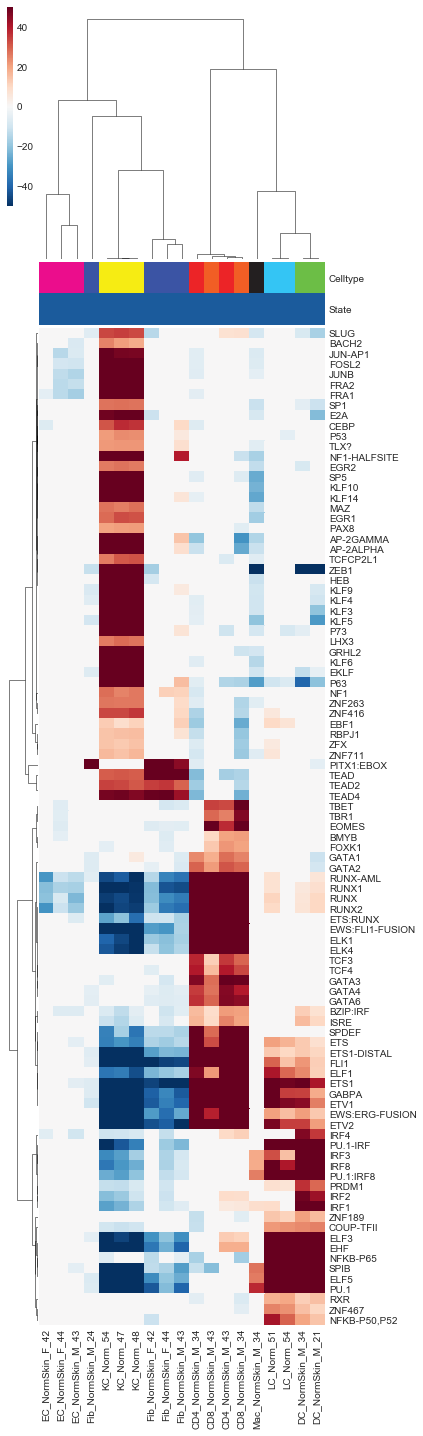

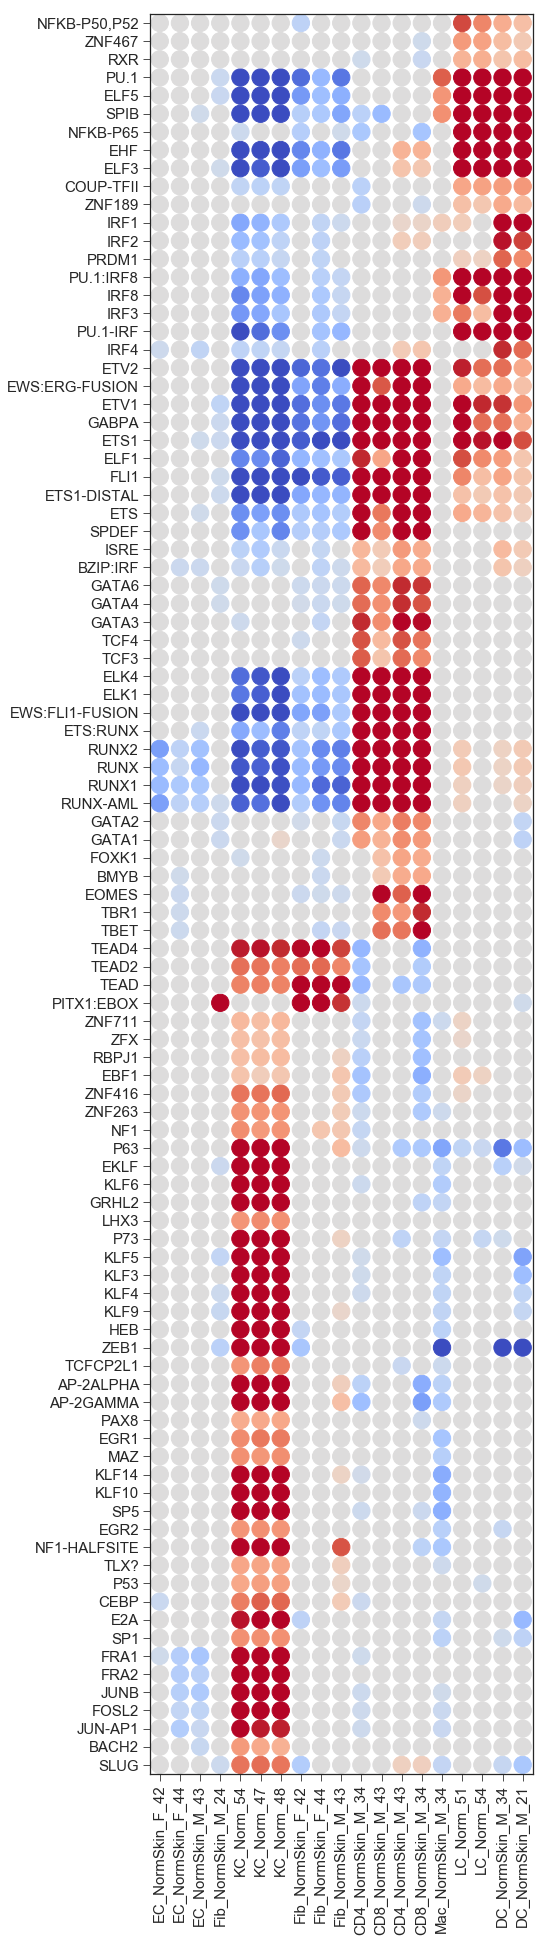

In [61]:
AllTFDF=Genomic_Display(os.path.join(NormGxrDir,'SpecificPeaks.gxr.txt'),NormGxrDir,colormap='RdBu_r',LabelDF=AllSampleColorDF,vmax=50,colorLabel=['Celltype','State'],topNum=100)                           



# with published data MRSS Correlation

### GSE76886

In [94]:
DirNorm=os.path.join(outDirNorm,'mRSSCorrelation_GSE76886_QNorm')
Mkdir(DirNorm)

ExpFile='/Users/liuqian/Documents/A_SSC_project/Reference_Data/MF_Trajectory/GSE76886_data_matrix_359samples.txt'
AnoFile='/Users/liuqian/Documents/A_SSC_project/A_Code_available/Published_Data/GSE76886/GPL6480-9577.txt'

ExpDF=ReadTable(ExpFile)         
AnoDF=ReadTable(AnoFile)
ExpDF.index=[i[15:] for i in list(ExpDF.index)]



In [95]:

ExpDF=ExpDF[[i for i in list(ExpDF) if ('SScMH' in i) and ('SScMH_01' not in i) and ('SScMH_S1001' not in i) and ('SScMH_02' not in i)]]            

ClinicalDF=pd.DataFrame({'MRSS':[21,21,8,8,7,7,4,4,21,21,3, 3, 3, 3,3, 3, 9, 9,21,21,32,32,11,11,11,11,9,9,20,20,16,16,4,4,3,3,3,3,3,3,4,4,9,9,10,10,11,11,12,12,12,12,13,13,7,7,9,9,9,9,13,13,17,17,15,15,14,14,12,12,14,14,17,17,'NA','NA','NA','NA','NA','NA','NA','NA','NA','NA',41, 41,41, 41,36,36,20,20,8,8,9,9,3,3,14,14,35, 31, 19, 15,35,35,'NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA',16,16,12,12,7,7,7,7,1,1,3,3,12,12,5,5,4,4,4,4,7,7,15,15,10,10,6,6,7,7,13,13,'NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA','NA',9,9,10,10,11,11,7,7,9,9,'NA','NA',13,13,8,8,4,4,17,17,15,15,1,1,2,2,3,3,3,3,11,11, 5,5, 8,8,9,9,'NA','NA','NA','NA',6,6,3,3,7,7,0,0,0,0,4,4,13,13,15,15,'NA','NA','NA','NA','NA','NA',3,3,3,3,10,10,6,6,16,16,'NA','NA',12,12,10,10,12,12,15,15,11,11,18,18,15,15,11,11,14,14,17,17,16,16,15,15]},index=ExpDF.columns)          
ClinicalDF['Patients']=[i.split('_')[1] for i in list(ClinicalDF.index)]
ClinicalDF['Time']=[i.split('_')[2] for i in list(ClinicalDF.index)]

ArrayRatio=((ExpDF>-1000000).apply(sum,axis=1)/len(list(ExpDF)))
ExpDF=ExpDF[(ExpDF.apply(np.max,axis=1)>0)&(ArrayRatio>0.8)]

FinalIndex=list(ClinicalDF[ClinicalDF['MRSS']!='NA'].index)
ExpDF=ExpDF[FinalIndex]
ClinicalDF=ClinicalDF.loc[FinalIndex]



In [96]:

MRSS_Inter=[]
for i in list(ClinicalDF['MRSS']):
    if 0<=i<=10:
        MRSS_Inter.append('0-10')
    elif 10<i<=20:
        MRSS_Inter.append('10-20')
    elif i>20:
        MRSS_Inter.append('20+')
ClinicalDF['MRSS_Inter']=MRSS_Inter



In [97]:
All_Oligo=[i for i in list(ExpDF.index) if i in list(AnoDF.index)]
ExpDF=ExpDF.loc[All_Oligo]


In [98]:
QNorm
rank_mean=ExpDF.stack().groupby(ExpDF.rank(method='first').stack().astype(int)).mean()
ExpDF=ExpDF.rank(method='min').stack().astype(int).map(rank_mean).unstack()


NameError: name 'QNorm' is not defined

In [ ]:
#DEseq Normalization
#SizeFactor=(ExpDF.T/ExpDF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
#ExpDF=ExpDF/SizeFactor


In [ ]:

ClinicalDF['Time2']=[int(i.split('mo')[0]) if (i!='base') and (i!='Base') else 0 for i in list(ClinicalDF['Time'])]            
ClinicalDF['Samples']=[i.split('_')[1] for i in ClinicalDF.index]
ClinicalDF['Last']=[i.split('_')[-1] for i in ClinicalDF.index]
ClinicalDF['MRSS']=[int(i) for i in ClinicalDF['MRSS']]
ClinicalDF['State']=['SSc']*len(ClinicalDF)
Improver=['03','04','06','10','16','21','30','33','42','45']



## MMF Response Genes (Uninvolved back skin)

In [ ]:
#Affected skin
Before=ClinicalDF[(ClinicalDF['Time2']==0) &(ClinicalDF['Last']=='LA')]
After=ClinicalDF[((ClinicalDF['Time2']==24)|(ClinicalDF['Time2']==12)) & (ClinicalDF['Last']=='LA')]              
BExp=ExpDF[list(Before.index)]
AExp=ExpDF[list(After.index)]
Diff_Affected,Pval_Affected,_,_=Diff_FDR(AExp,BExp,1,0.05)




In [ ]:
AllDiffProbs=list(BExp[(abs(Diff_Affected)>0.1)&(Pval_Affected<0.1)].index)
ResponseGenes=AnoDF.loc[AllDiffProbs]['GENE_SYMBOL'].dropna()

In [ ]:

Save(ResponseGenes, os.path.join(DirNorm,'MMF_ResponseGenes.txt'))


In [ ]:
v = venn2(subsets=(1,1,3))
v.get_label_by_id('100').set_text('First')
v.get_label_by_id('010').set_text('Second')
plt.title("Not a Venn diagram")
plt.show()


In [ ]:
DirNorm


## Signature Genes

In [ ]:
def Norm01(L):
    newL=[i for i in L if i!=np.nan]
    Min=min(newL)
    R=max(newL)-Min
    return [float(i-Min)/R for i in L]

def RandomModel_Qvalue(ClinicalDF_input,R,P,N,Rep=1000):
    random.seed(666)
    P_random=[]
    R_random=[]
    for n in range(Rep):
        if n%200==0:
            print n
        r,p=scipy.stats.pearsonr(ClinicalDF_input['MRSS'],ExpDF[ClinicalDF_input.index].loc[random.sample(ExpDF.index,N)].apply(np.mean,axis=0))                  
        P_random.append(p)
        R_random.append(r)
    return sum([1 for i in range(Rep) if (P_random[i]<P) or (R_random[i]>R)])/float(Rep)


def Scatterplot(df,x,y,N,label,Dir,hue='State'):
    plt.style.use('seaborn-white')
#     fig1=plt.figure(figsize=(4,5))
#     ax1=fig1.add_axes([0.15,0.15,0.75,0.75])
    sns.lmplot(x=x, y=y, hue=hue,data=df,palette={'Affected':'#343086','SSc':'#343086'})
    R,P=scipy.stats.pearsonr(df[x],df[y])
    Q=RandomModel_Qvalue(df,R,P,N,Rep=1000)
    Title='Relation:{},Pval:{},Qval:{}'.format(str(R),str(P),str(Q))
    plt.title(Title)
    plt.tick_params(labelsize=20,length=5,direction='out')
    plt.savefig(os.path.join(Dir,label+'.lmPlot.pdf'))
    plt.show()
    
def BoxSwarmplot(df,x,y,label,Dir):
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(2,3))
    ax=fig.add_axes([0.15,0.15,0.75,0.75])
    sns.boxplot(x=x,y=y,data=df,linewidth=0.5,order=['Norm','Unaffected','Affected'],width=0.65,palette={'Norm':'#696BA8','Affected':'#D56566','Unaffected':'#E7A58A'},ax=ax,fliersize=0) 
    sns.swarmplot(x=x,y=y,data=df,order=['Norm','Unaffected','Affected'],palette={'Norm':'#303082','Affected':'#C22227','Unaffected':'#CE5C27'},size=4,linewidth=0,ax=ax,dodge=True) 
    N=df[df[x]=='Norm'][y]
    A=df[df[x]=='Affected'][y]
    U=df[df[x]=='Unaffected'][y]
    _,p1=scipy.stats.mannwhitneyu(N,A)
    _,p2=scipy.stats.mannwhitneyu(N,U)
    _,p3=scipy.stats.mannwhitneyu(A,U)
    plt.title('N-A:{}, N-U:{},U-A:{}'.format(str(p1),str(p2),str(p3)))
    plt.tick_params(labelsize=8,length=2,direction='out')
    plt.savefig(os.path.join(Dir,label+'.BoxSwarmPlot.pdf'))
    plt.show()
    

def GetSignatueGenes(Dir,Celltypes,Label,BedDF,CellTypeSpecificPeaks_Dict, PeakAnoDF ):
    Dir=os.path.join(Dir,Label)
    Mkdir(Dir)
    Peaks=[]
    for i in Celltypes:
        Peaks=Peaks+CellTypeSpecificPeaks_Dict[i]
    DF=BedDF.loc[list(set(Peaks))]
    DF['Genes']=PeakAnoDF.loc[DF.index]['Gene Name']
    SaveBed(DF, os.path.join(Dir, Label+'.Specific.PeaksAndGenes.txt'))
    Genes=list(set(DF['Genes'].dropna()))
    Probs=[]
    for g in Genes:
        Probs=Probs+list(AnoDF[AnoDF['GENE_SYMBOL']==g].index)
    Probs=list(set(Probs))
    
    Overlap=[i for i in Probs if i in list(ResponseGenes.index)]
    Probs_rmMMF=[i for i in Probs if i not in list(ResponseGenes.index)]
    v = venn2(subsets=(len(Probs_rmMMF),len(ResponseGenes)-len(Overlap),len(Overlap)))
    v.get_label_by_id('100').set_text('Celltype_Specific\n'+str(len(Probs_rmMMF)))
    v.get_label_by_id('010').set_text('MMF_ResponseGenes\n'+str(len(ResponseGenes)-len(Overlap)))
    plt.savefig(os.path.join(Dir,'Venn.Celltype_SpecificProbs.Overlap.MMF_ResponseGenes.pdf'))

    
    
    ExpDF_Peaks=ExpDF.loc[Probs].dropna(how='all')
    ExpDF_Peaks=ExpDF_Peaks[ExpDF_Peaks.apply(np.max,axis=1)>0]
    Label=Label+'.'+str(len(Probs))
    ClinicalDF[Label]=ExpDF_Peaks.apply(np.mean,axis=0)
    
    ExpDF_Peaks=ExpDF.loc[Probs_rmMMF].dropna(how='all')
    ExpDF_Peaks=ExpDF_Peaks[ExpDF_Peaks.apply(np.max,axis=1)>0]
    Label_rmMMF=Label.split('.')[0]+'.'+str(len(Probs_rmMMF))+'.Remove_MMF_ResponseGenes'
    ClinicalDF[Label_rmMMF]=ExpDF_Peaks.apply(np.mean,axis=0)
    
    
    ClinicalDF_LA=ClinicalDF[ClinicalDF['Last']=='LA']
    ClinicalDF_LF=ClinicalDF[ClinicalDF['Last']=='LF']
    ClinicalDF_Improver_LA=ClinicalDF_LA.loc[[i for i in ClinicalDF_LA.index if ClinicalDF_LA.loc[i]['Patients'] in Improver]]
    ClinicalDF_Improver_LF=ClinicalDF_LF.loc[[i for i in ClinicalDF_LF.index if ClinicalDF_LF.loc[i]['Patients'] in Improver]]
    ClinicalDF_Improver=ClinicalDF.loc[[i for i in ClinicalDF.index if ClinicalDF.loc[i]['Patients'] in Improver]]
    
    
    Scatterplot(ClinicalDF_LA,'MRSS',Label,len(Probs),Label+'_SamplesLA',Dir,hue='State')
    Scatterplot(ClinicalDF_LF,'MRSS',Label,len(Probs),Label+'_SamplesLF',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver_LA,'MRSS',Label,len(Probs),Label+'_Samples_ImproverLA',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver_LF,'MRSS',Label,len(Probs),Label+'_Samples_ImproverLF',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver,'MRSS',Label,len(Probs),Label+'_AllSamples_Improver',Dir,hue='State')
    Scatterplot(ClinicalDF,'MRSS',Label,len(Probs),Label+'_AllSamples',Dir,hue='State')
    
    #rmMMF=remove MMF response genes
    Scatterplot(ClinicalDF_LA,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_SamplesLA',Dir,hue='State')
    Scatterplot(ClinicalDF_LF,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_SamplesLF',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver_LA,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_Samples_ImproverLA',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver_LF,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_Samples_ImproverLF',Dir,hue='State')
    Scatterplot(ClinicalDF_Improver,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_AllSamples_Improver',Dir,hue='State')
    Scatterplot(ClinicalDF,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_AllSamples',Dir,hue='State')
    
    
    #### Lowest MRSS and highest MRSS of one patients
    
    def GetPatientDF(Clinicaldf,Dir, label):
        plt.style.use('seaborn-white')
        fig1=plt.figure(figsize=(2,5))
        ax1=fig1.add_axes([0.15,0.15,0.75,0.75])   
        AllPatients=set(Clinicaldf['Patients'])
        Clinicaldf_Patients=pd.DataFrame({},index=AllPatients)
        MinMRSS=[]
        MaxMRSS=[]
        Patients=[]
        MinScore=[]
        MaxScore=[]
        for p in AllPatients:
            subdf=Clinicaldf[Clinicaldf['Patients']==p]
            minMrss=min(subdf['MRSS'])
            maxMrss=max(subdf['MRSS'])
            if maxMrss-minMrss>5:
                MIN=np.mean(Clinicaldf.loc[list(subdf[subdf['MRSS']==minMrss].index)][Label])
                MAX=np.mean(Clinicaldf.loc[list(subdf[subdf['MRSS']==maxMrss].index)][Label])
                ax1.plot([0.5,1.5],[MIN,MAX],linewidth=2,color='K',marker='o',markersize=5)
                MinMRSS.append(minMrss)
                MaxMRSS.append(maxMrss)
                Patients.append(p)
                MinScore.append(MIN)
                MaxScore.append(MAX)
        outDF=pd.DataFrame({'Minimum_mRSS':MinMRSS,'Maxmum_mRSS':MaxMRSS,label+'_of_Samples_With_Minimum_mRSS':MinScore,label+'_of_Samples_With_Maxmum_mRSS':MaxScore},index=Patients)        
        Save(outDF,os.path.join(Dir,label+'.min_and_max.mRSS_SignatureScore.individuals.txt'))
        plt.title(scipy.stats.ttest_rel(MinScore,MaxScore,nan_policy='propagate')[1])
        plt.tick_params(labelsize=20,length=5,direction='out')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.savefig(os.path.join(Dir,label+'.min_and_max.mRSS_SignatureScore.individuals.pdf'))    
        plt.show()   
    #rmMMF=remove MMF response genes
    GetPatientDF(ClinicalDF_LA,Dir, Label+'_SamplesLA')            
    GetPatientDF(ClinicalDF_LF,Dir, Label+'_SamplesLF')
    GetPatientDF(ClinicalDF_Improver_LA,Dir, Label+'_Samples_ImproverLA')
    GetPatientDF(ClinicalDF_Improver_LF,Dir, Label+'_Samples_ImproverLF')
    GetPatientDF(ClinicalDF_Improver,Dir, Label+'_AllSamples_Improver')
    GetPatientDF(ClinicalDF,Dir, Label+'_AllSamples')
    
    GetPatientDF(ClinicalDF_LA,Dir, Label_rmMMF+'_SamplesLA')
    GetPatientDF(ClinicalDF_LF,Dir, Label_rmMMF+'_SamplesLF')
    GetPatientDF(ClinicalDF_Improver_LA,Dir, Label_rmMMF+'_Samples_ImproverLA')
    GetPatientDF(ClinicalDF_Improver_LF,Dir, Label_rmMMF+'_Samples_ImproverLF')
    GetPatientDF(ClinicalDF_Improver,Dir, Label_rmMMF+'_AllSamples_Improver')
    GetPatientDF(ClinicalDF,Dir, Label_rmMMF+'_AllSamples')
    
    

In [ ]:

for cts in [['Fib'],['DC-LC'],['DC'],['DC-LC','DC'],['LC'],['EC'],['CD4','CD4-CD8','CD8'],['Mac'],['KC']]:
    print cts
    GetSignatueGenes(DirNorm,cts,'All.'+'_'.join(cts),NormBedDF,NormCellTypeSpecificPeaks_Dict, NormAnoDF )

Save(ClinicalDF, os.path.join(DirNorm,'CelltypeSignatureScore.txt')) 

